In [1]:
# packge import 
import torch
from configs.config_task1 import get_cfg_defaults
from data.argument_type import Mixup,Cutmix
from data.dataset import load_cifar_dataset
from task1_train import prepare_config
from configs.config_task1 import get_cfg_defaults
from model.resnet import ResNet18
from torchmetrics.functional import accuracy, precision_recall,f1_score
from tqdm import tqdm

In [2]:
cfg = get_cfg_defaults()
cfg.TRAIN.batch_size = 3

In [3]:
# load data

train_dataset,test_dataset,num_classes = load_cifar_dataset(cfg)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=cfg.TRAIN.batch_size,
                                            shuffle=False,
                                            pin_memory=False,
                                            num_workers=2)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=cfg.TRAIN.batch_size,
                                            shuffle=False,
                                            pin_memory=False,
                                            num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
model = ResNet18(num_classes=num_classes)

In [5]:
# baseline
model.load_state_dict(torch.load('trained_model/resnet18_(False, False, False, False)/best_model.pt'))
model = model.to('cuda:0')

In [8]:
# cutout
model.load_state_dict(torch.load('trained_model/resnet18_(False, True, False, False)/best_model.pt'))
model = model.to('cuda:0')

In [20]:
#Cutmix
model.load_state_dict(torch.load('trained_model/resnet18_(False, False, True, False)/best_model.pt'))
model = model.to('cuda:0')

In [21]:
# inference 
model.eval()
# train 
preds = []
targets = []
for images, labels in tqdm(train_loader):
    images = images.to('cuda:0')
    labels = labels.to('cuda:0')

    with torch.no_grad():
        pred = model(images)

    pred = torch.max(pred.data, 1)[1]
    preds.append(pred)
    targets.append(labels)
preds = torch.cat(preds)
targets = torch.cat(targets)
acc = accuracy(preds,targets)
pre,recall = precision_recall(preds, targets, average='macro', num_classes=num_classes)
f1 = f1_score(preds,targets,num_classes = num_classes)
print(acc.item(),pre.item(),recall.item(),f1.item())

100%|██████████| 49/49 [00:08<00:00,  5.51it/s]

0.9991199970245361 0.9991238117218018 0.9991199970245361 0.9991199970245361


In [19]:
# test
preds = []
targets = []
for images, labels in tqdm(test_loader):
    images = images.to('cuda:0')
    labels = labels.to('cuda:0')

    with torch.no_grad():
        pred = model(images)

    pred = torch.max(pred.data, 1)[1]
    preds.append(pred)
    targets.append(labels)
preds = torch.cat(preds)
targets = torch.cat(targets)
acc = accuracy(preds,targets)
pre,recall = precision_recall(preds, targets, average='macro', num_classes=num_classes)
f1 = f1_score(preds,targets,num_classes = num_classes)
print(acc.item(),pre.item(),recall.item(),f1.item())

100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

0.5077999830245972 0.5253576040267944 0.5077999830245972 0.5077999830245972


In [37]:
import numpy as np
def mixup_data( x1, x2,y1,y2,alpha):
        '''Returns mixed inputs, pairs of targets, and lambda'''
        lam=0.5
        mixed_x = lam * x1 + (1 - lam) * x2
        y_a, y_b = y1,y2
        return mixed_x, (y_a, y_b), lam

In [45]:
def rand_bbox(size, lam):
        W = size[1]
        H = size[2]
        cut_rat = np.sqrt(1. - lam)
        cut_w = np.int(W * cut_rat)
        cut_h = np.int(H * cut_rat)

        # uniform
        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2
def cutmix_data(x1,x2,y1,y2,lam):
    # generate mixed sample
    
    target_a = y1
    target_b = y2
    bbx1, bby1, bbx2, bby2 = rand_bbox(x1.size(), lam)
    x1[:, bbx1:bbx2, bby1:bby2] = x2[:, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x1.size()[-1] * x2.size()[-2]))
    # compute output
    return x1,(target_a,target_b),lam

torch.Size([3, 3, 32, 32])
0.5
0.5
0.5


/remote-home/rpluo/miniconda3/envs/cuda11.2/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/remote-home/rpluo/miniconda3/envs/cuda11.2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current

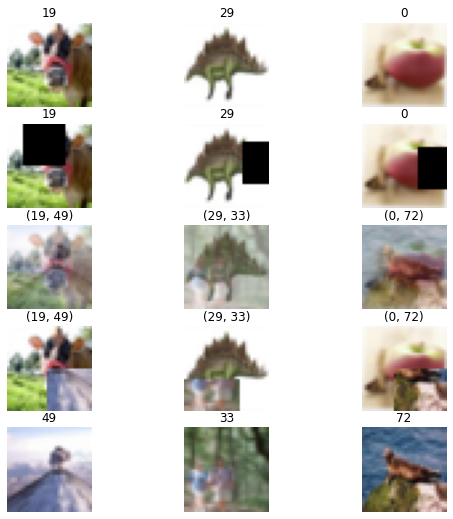

In [46]:
# visualize
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from data.argument_type import Cutout,Mixup,Cutmix
#%% 训练数据可视化

images, labels = next(iter(train_loader))
mix_images, mix_labels = next(iter(test_loader))
print(images.size())  # torch.Size([9, 1, 28, 28])
plt.figure(figsize=(9, 9))
cutout = Cutout(1,16)
mixup = Mixup(alpha=0.5)
for i in range(3):
    plt.subplot(5, 3, i+1)
    plt.title(labels[i].item())
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis('off')

cutout_images = images.clone()
for i in range(3):
    cutout_images[i] = cutout(cutout_images[i])
    plt.subplot(5, 3, i+4)
    plt.title(labels[i].item())
    plt.imshow(cutout_images[i].permute(1, 2, 0))
    plt.axis('off')
mixup_images = images.clone()
for i in range(3):
    mixup_images[i],mixup_labels,lam = mixup_data(images[i],mix_images[i],labels[i],mix_labels[i],alpha=0.5)
    print(lam)
    plt.subplot(5, 3, i+7)
    plt.title((mixup_labels[0].item(),mixup_labels[1].item()))
    plt.imshow(mixup_images[i].permute(1, 2, 0))
    plt.axis('off')

for i in range(3):
    cutmix_img,mixup_labels,lam = cutmix_data(images[i],mix_images[i],labels[i],mix_labels[i],lam=0.5)
    plt.subplot(5, 3, i+10)
    plt.title((mixup_labels[0].item(),mixup_labels[1].item()))
    plt.imshow(cutmix_img.permute(1, 2, 0))
    plt.axis('off')

for i in range(3):
    plt.subplot(5, 3, i+13)
    plt.title(mix_labels[i].item())
    plt.imshow(mix_images[i].permute(1, 2, 0))
    plt.axis('off')
plt.show()